/Users/choir/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


      user_id  movie_id  rating  \
7389       49       299       2   
9275      201       462       1   
2995      276       301       4   
5316      234       519       5   
356       104       984       1   

                                                  title  
7389                                     Hoodlum (1997)  
9275  Like Water For Chocolate (Como agua para choco...  
2995                                    In & Out (1997)  
5316           Treasure of the Sierra Madre, The (1948)  
356                            Shadow Conspiracy (1997)  
------------------------------------------------------------------------------------
Training data movies for the user userid: 166:
------------------------------------------------------------------------------------
Contact (1997)
Conspiracy Theory (1997)
Jackie Brown (1997)
Murder at 1600 (1997)
Alien: Resurrection (1997)
----------------------------------------------------------------------
Recommendation process going on:
-----------

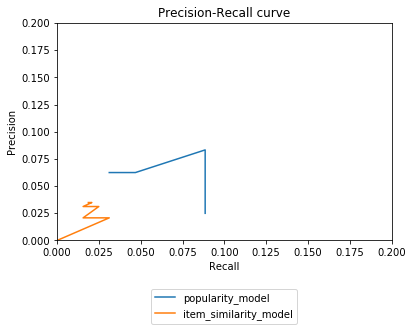

In [1]:
import pandas as pd
from sklearn.cross_validation import train_test_split
import numpy as np
import time
from sklearn.externals import joblib
import Recommenders as Recommenders
import Evaluation as Evaluation


#Read movie  metadata
rating_cols = ['user_id', 'movie_id', 'rating']
rating_data = pd.read_csv('../ml-100k/u.data', header=None, sep='\t', encoding='latin1', names=rating_cols, usecols=range(3))

title_cols = ['movie_id', 'title']
title_data = pd.read_csv('../ml-100k/u.item', sep='|', encoding='latin1', names=title_cols, usecols=range(2))

#Merge the two dataframes to create input dataframe
movie_data = pd.merge(rating_data, title_data.drop_duplicates(['movie_id']), on="movie_id", how="left") 

movie_data = movie_data.head(10000)

movie_grouped = movie_data.groupby(['title']).agg({'rating': 'count'}).reset_index()
grouped_sum = movie_grouped['rating'].sum()
movie_grouped['percentage']  = movie_grouped['rating'].div(grouped_sum)*100
movie_grouped.sort_values(['rating', 'title'], ascending = [0,1])

users = movie_data['user_id'].unique()
movies = movie_data['title'].unique()

train_data, test_data = train_test_split(movie_data, test_size = 0.20, random_state=0)
print(train_data.head())

pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'user_id', 'title')

user_id = users[0]
pm.recommend(user_id)

sm = Recommenders.item_similarity_recommender_py()
sm.create(train_data, 'user_id', 'title')

#Print the movies for the user in training data
user_id = users[5]
user_items = sm.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data movies for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend movies for the user using personalized model
sm.recommend(user_id)

movie = 'Toy Story (1995)'
###Fill in the code here
sm.get_similar_items([movie])

start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = Evaluation.precision_recall_calculator(test_data, train_data, pm, sm)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

import pylab as pl

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()
    
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")    
